In [25]:
from scipy.io import savemat
import scipy.io     # used to load .mat data

import pandas as pd
import numpy as np
import pickle as pkl
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import seaborn as sns

from models import TandemNet, MLP ,cVAE, cGAN, INN, cVAE_new, cVAE_GSNN
from models import MLP, TandemNet, cVAE, cGAN, INN, cVAE_new, cVAE_GSNN, cVAE_Full, cVAE_hybrid, cVAE_tandem, cVAE_GSNN1
from utils import evaluate_tandem_minmax_accuracy, evaluate_forward_minmax_dataset, evaluate_forward_minmax, evaluate_vae_GSNN_minmax_inverse, evaluate_gan_minmax_inverse, evaluate_inn_minmax_inverse
from configs import get_configs
from plotting_utils import compare_cie_dist, compare_param_dist, plot_cie, plot_cie_raw_pred, plt_abs_err, plt_hist_struc, plot_struc_raw_pred
from datasets import get_dataloaders, SiliconColor
from matplotlib import pyplot as plt

from sklearn.metrics import r2_score

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
train_loader, val_loader, test_loader = get_dataloaders('forward_model')




In [1]:
from colour.plotting import plot_chromaticity_diagram_CIE1931
from colour.plotting.characterisation import colour_checker_plot
plot_chromaticity_diagram_CIE1931()

ImportError: cannot import name 'colour_checker_plot' from 'colour.plotting.characterisation' (/home/taigaom/.local/lib/python3.8/site-packages/colour/plotting/characterisation.py)

In [2]:
colour_checker_plot(colour_checker='ColorChecker 2005', text_display=False)

NameError: name 'colour_checker_plot' is not defined

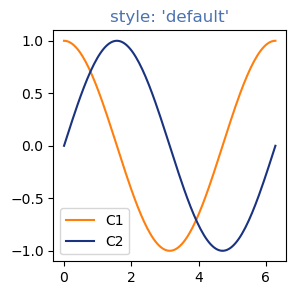

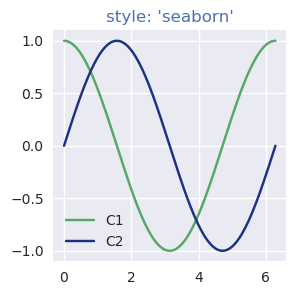

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

th = np.linspace(0, 2*np.pi, 128)


def demo(sty):
    mpl.style.use(sty)
    fig, ax = plt.subplots(figsize=(3, 3))

    ax.set_title('style: {!r}'.format(sty), color='C0')

    ax.plot(th, np.cos(th), 'C1', label='C1')
    ax.plot(th, np.sin(th), 'C2', label='C2', color = (0.1, 0.2, 0.5))
    ax.legend()


demo('default')

demo('seaborn')

In [61]:
# choose 10 random CIE
# compare the results of inverse design: tandem, VAE, GAN

def insert_xyY(xyY, B):

    a = len(B)
    for i in range(a):
        xyY = np.insert(xyY, B[i], 0, axis=0)

    return xyY

# load tandem:

filepath_tandem = "./data_predicted/param_tandem_pred.mat"
temp = scipy.io.loadmat(filepath_tandem)
insert_tandem = list(list(temp.items())[7][1][0,:])
filepath_tandem ="./data_predicted/xyY/xyY_param_tandem_pred.mat"
temp = scipy.io.loadmat(filepath_tandem)
xyY_tandem = insert_xyY(np.array(list(temp.items())[7][1]), insert_tandem)

# load vae:
filepath_vae = "./data_predicted/param_vae_hybrid_GSNN1_1_pred.mat"
temp = scipy.io.loadmat(filepath_vae)
insert_vae = list(list(temp.items())[7][1][0,:])
filepath_vae = "./data_predicted/xyY/xyY_param_vae_hybrid_GSNN1_1_pred.mat"
temp = scipy.io.loadmat(filepath_vae)
xyY_vae = insert_xyY(np.array(list(temp.items())[7][1]), insert_vae)

# load GAN:
filepath_gan = "./data_predicted/param_cgan_pred.mat"
temp = scipy.io.loadmat(filepath_gan)
insert_gan = list(list(temp.items())[7][1][0,:])
filepath_gan = "./data_predicted/xyY/xyY_param_cgan_pred.mat"
temp = scipy.io.loadmat(filepath_gan)
xyY_gan = insert_xyY(np.array(list(temp.items())[7][1]), insert_gan)

# load the original CIE: 
filepath_cie = "./data_predicted/param_cgan_pred_all.mat"
temp = scipy.io.loadmat(filepath_cie)
xyY_original = np.array(list(temp.items())[6][1])




Text(0, 0.5, 'GAN designed')

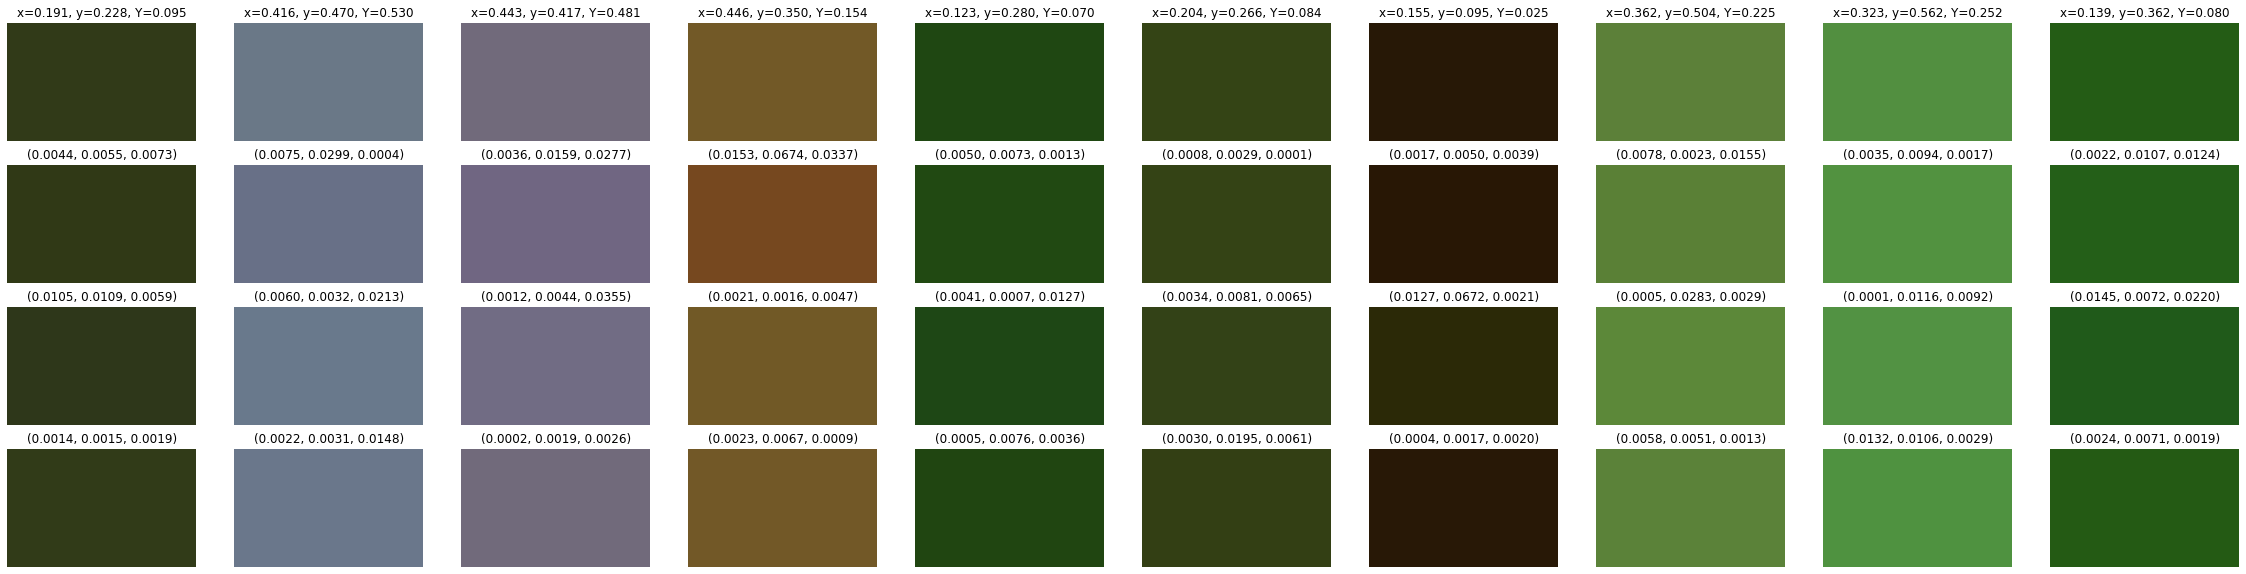

In [75]:
# Choose 10 CIE

M = len(xyY_original)
N = 10
row_cie = np.random.randint(M, size=10)

fig, axs = plt.subplots(4, N, figsize=[40,10])
x = [0,0.5,1]
y = [1,1,1]

abs_tandem = abs(xyY_tandem[row_cie,:]-xyY_original[row_cie,:])
abs_vae = abs(xyY_vae[row_cie,:]-xyY_original[row_cie,:])
abs_gan = abs(xyY_gan[row_cie,:]-xyY_original[row_cie,:])

def xyY_to_XYZ(xyY):
    # http://www.brucelindbloom.com/index.html?Eqn_xyY_to_XYZ.html
    a = len(xyY)
    XYZ = np.zeros([a, 3])
    for i in range(a):
        XYZ[i,0] = xyY[i,0]*xyY[i,2]/xyY[i,1]
        XYZ[i,1] = xyY[i,2]
        XYZ[i,2] = (1-xyY[i,0]-xyY[i,1])*xyY[i,2]/xyY[i,1]
    
    return XYZ

def XYZ_to_RGB(XYZ):
    

for i in range(N):
     axs[0,i].plot(x, y, color=xyY_original[row_cie[i],:], linewidth=300)
     axs[0,i].set_title('x={:.3f}, y={:.3f}, Y={:.3f}'.format(xyY_original[row_cie[i],0],xyY_original[row_cie[i],1],xyY_original[row_cie[i],2]))
     axs[0,i].axis('off')
     axs[1,i].plot(x, y, color=xyY_tandem[row_cie[i],:], linewidth=300)
     axs[1,i].set_title('({:.4f}, {:.4f}, {:.4f})'.format(abs_tandem[i,0],abs_tandem[i,1],abs_tandem[i,2]))
     axs[1,i].axis('off')
     axs[2,i].plot(x, y, color=xyY_vae[row_cie[i],:], linewidth=300)
     axs[2,i].set_title('({:.4f}, {:.4f}, {:.4f})'.format(abs_vae[i,0],abs_vae[i,1],abs_vae[i,2]))
     axs[2,i].axis('off')
     axs[3,i].plot(x, y, color=xyY_gan[row_cie[i],:], linewidth=300)
     axs[3,i].set_title('({:.4f}, {:.4f}, {:.4f})'.format(abs_gan[i,0],abs_gan[i,1],abs_gan[i,2]))
     axs[3,i].axis('off')

axs[0,0].set_ylabel('Original')
axs[1,0].set_ylabel('Tandem designed')
axs[2,0].set_ylabel('VAE designed')
axs[3,0].set_ylabel('GAN designed')







In [71]:
xyY_gan[row_cie, :]

array([[ 0.43822465,  0.41497119,  0.09414247],
       [ 0.16732281,  0.3786257 ,  0.09227154],
       [ 0.45841743,  0.30826087,  0.23576975],
       [ 0.12922714,  0.21459328,  0.06995649],
       [ 0.23791011,  0.3001234 ,  0.13995115],
       [ 0.35401188,  0.44709968,  0.17626128],
       [ 0.38994842,  0.4300141 ,  0.32136085],
       [ 0.30727182,  0.37938301,  0.33394927],
       [ 0.21595611,  0.24679062,  0.09801821],
       [ 0.202925  ,  0.26713956,  0.09952469]])

(-0.050000000000000003, 1.05, 0.94499999999999995, 1.0550000000000002)

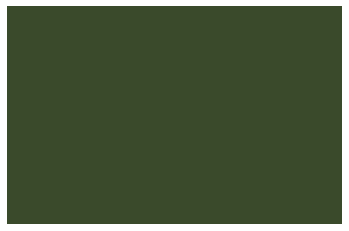

In [34]:
x = [0,0.5,1]
y = [1,1,1]

plt.plot(x,y, color= xyY_original[100,:], linewidth=300)
plt.axis('off')